# Advanced Econometrics GA I

## Libraries

In [1]:
#FIRST RUN THIS

#import all libraries and load the data:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln, expit
from scipy.optimize import minimize
import math

## Data Initialization

In [5]:
# Load the CSV file
path_of_file = 'stock_data_csv.csv'
data = pd.read_csv(path_of_file)

#MULTIPLY DATA x100
data['RET'] = data['RET'].astype(float)*100

In [6]:
data.head()

,PERMNO,date,TICKER,RET
0,14593,2011-01-03,AAPL,2.1732
1,14593,2011-01-04,AAPL,0.5219
2,14593,2011-01-05,AAPL,0.8180
3,14593,2011-01-06,AAPL,-0.0808
4,14593,2011-01-07,AAPL,0.7161


## Q2

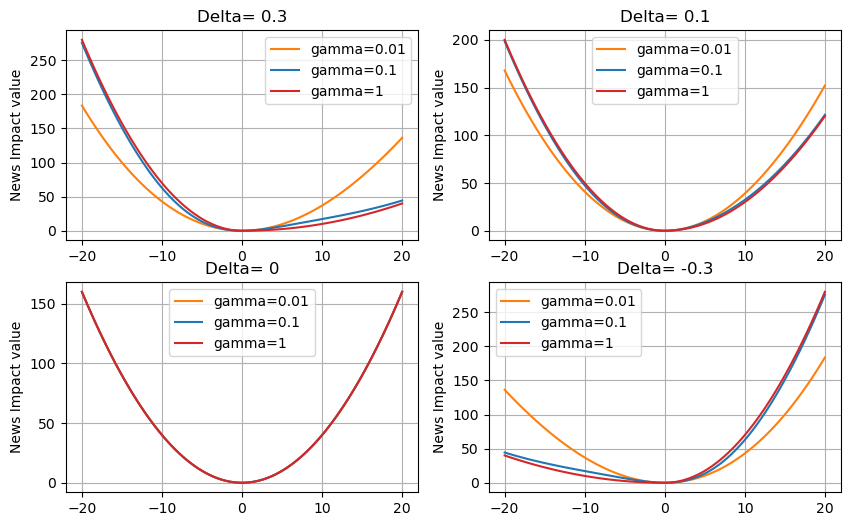

In [8]:
#Question 2

def news_impact_funct(xt, gamma, delta, alpha):
    ''' This function returns the news impact output '''
    
    return (alpha+delta*np.tanh(-gamma*xt))*(xt**2)

#defin the parameters
gammas = [0.01, 0.1, 1]
deltas = [0.3, 0.1, 0, -0.3]
xt_linspace = np.linspace(-20, 20, 100)  #TODO: what range do we put for returns?? +- 20 dollars?
alpha = 0.4

#create 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
scientific_colors = ["#ff7f0e", "#1f77b4", "#d62728"] #orange, blue, red

#loop through deltas (or strictly speaking the iterate over the axes) to make plots
for i, ax in enumerate(axs.flatten()):
    #loop through gammas and plot for the delta we're at
    for j in range(len(gammas)):
        news_impact = news_impact_funct(xt_linspace, gammas[j], deltas[i], alpha)
        ax.plot(xt_linspace, news_impact, label=f'gamma={gammas[j]}', color=scientific_colors[j])
    
    ax.set_title(f'Delta= {deltas[i]}')
    ax.set_ylabel('News Impact value')
    ax.legend()
    ax.grid()   #for a grid

#plt.savefig('figure_Q2.png') #first save, then show. Otherwise this will result in blank image
plt.show()


## Q4

In [10]:
# Data structuring
#AAPL
data_ml = data.iloc[:2500].copy()

#MRK
data_mrk = data[data['TICKER'] == 'MRK'].copy()
data_mrk = data_mrk.reset_index(drop=True)
data_mrk_ml = data_mrk.iloc[:2500].copy()

#JNJ
data_jnj = data[data['TICKER'] == 'JNJ'].copy()
data_jnj = data_jnj.reset_index(drop=True)
data_jnj_ml = data_jnj.iloc[:2500].copy()

#PFE
data_pfe = data[data['TICKER'] == 'PFE'].copy()
data_pfe = data_pfe.reset_index(drop=True)
data_pfe_ml = data_pfe.iloc[:2500].copy()

In [70]:
data_ml.tail()

,PERMNO,date,TICKER,RET
2495,14593,2020-12-01,AAPL,3.0827
2496,14593,2020-12-02,AAPL,0.2934
2497,14593,2020-12-03,AAPL,-0.1137
2498,14593,2020-12-04,AAPL,-0.5613
2499,14593,2020-12-07,AAPL,1.2270


In [3]:
def garch_model(theta, data, mean_effect=False, leverage_effect=False):
    """
    This function computes the log-likelihood of a GARCH(1,1) model with Student's t-distributed errors.
    Using the mean and leverage effects are optional.
    These options will include additional parameters in the model.
    """
    
    # Using Link functions to ensure the parameters are within the required range
    omega = np.exp(theta[0])  # Ensures omega > 0
    alpha = np.exp(theta[1]) / (1 + np.exp(theta[1]))  # Ensures 0 < alpha < 1
    mu = theta[2]
    beta = np.exp(theta[3]) / (1 + np.exp(theta[3]))   # Ensures 0 < beta < 1
    nu = np.exp(theta[4])    # Ensures nu > 0

    if mean_effect:
        lambda_ = np.exp(theta[5]) / (1 + np.exp(theta[5]))  # Ensures lambda > 0
    else:
        lambda_ = 0

    if leverage_effect:
        gamma = np.exp(theta[6]) / (1 + np.exp(theta[6]))  # Ensures 0 < gamma < 1
        delta = theta[7]       # Directly used, ensure it remains within bounds relative to alpha
    else:
        gamma = 0
        delta = 0

    df = data.copy()
    
    sig2 = np.zeros(len(df))
    sig2[0] = np.var(df['RET'].iloc[:50])

    # Adjust delta if it exceeds alpha
    if leverage_effect:
        delta = delta if np.abs(delta) < alpha else np.sign(delta) * alpha * .99 #penalize if delta exceeds alpha

    for t in range(1, len(df)):
        news_impact = (alpha + (delta * np.tanh(-gamma * df['RET'][t-1]))) * ((df['RET'][t-1] - mu - (lambda_ * sig2[t-1])) / np.sqrt(sig2[t-1]))**2
        updating_eq = beta * sig2[t-1]
        sig2[t] = omega + news_impact + updating_eq

    epsilon = (df['RET'] - mu - (lambda_ * sig2)) / np.sqrt(sig2)

    llik = np.zeros(len(df))

    for t in range(len(df)):
        eps_t = epsilon[t]
        term1 = math.lgamma((nu + 1) / 2) - math.lgamma(nu / 2)
        term2 = -0.5 * np.log(nu * np.pi) - 0.5 * np.log(sig2[t])
        term3 = -(nu + 1) / 2 * np.log(1 + (eps_t**2) / nu)

        if mean_effect and leverage_effect:
            penalty = .001 * gamma**2

            llik[t] = term1 + term2 + term3 - penalty
        else:
            llik[t] = term1 + term2 + term3

    llik = np.sum(llik)

    return -llik

In [5]:
def theta_vector(data, mean_effect=False, leverage_effect=False):
    """
    This function returns the initial vector of parameters for the GARCH model.
    The mean and leverage effects are optional.
    The options enable the inclusion of additional parameters in the model.
    """

    omega = float(np.var(data['RET'])/50)
    alpha = .05
    mu = .001
    beta = .9
    nu = 10
    lambda_ = .001
    gamma = .01
    delta = .01

    #applying the link function to the parameters

    theta = [np.log(omega), np.log(alpha/(1-alpha)), mu, np.log(beta/(1-beta)), np.log(nu)]
    
    if mean_effect:
        theta.append(np.log(lambda_/(1-lambda_)))
    if leverage_effect:
        theta.append(np.log(gamma/(1-gamma)))
        theta.append(delta)
    
    return theta

In [7]:
def optimize_garch(data, theta, mean_effect=False, leverage_effect=False):
    """
    This function optimizes the GARCH model using the given data and initial parameters.
    The mean and leverage effects are optional.
    The options enable the inclusion of additional parameters in the model.
    The optimization process uses the L-BFGS-B method.
    """
    
    if mean_effect and leverage_effect:
        bounds = [
            (-np.inf, np.inf),   # omega
            (-np.inf, np.inf),   # alpha
            (-np.inf, np.inf),   # mu
            (-np.inf, np.inf),   # beta
            (1e-8, np.inf),      # nu (nu > 0)
            (-np.inf, np.inf),   # lambda
            (-np.inf, np.inf),   # gamma
            (-1, 1)    # delta
        ]
    elif mean_effect and not leverage_effect:
        bounds = [
            (-np.inf, np.inf),   # omega
            (-np.inf, np.inf),   # alpha
            (-np.inf, np.inf),   # mu
            (-np.inf, np.inf),   # beta
            (1e-8, np.inf),      # nu (nu > 0)
            (-np.inf, np.inf)    # lambda
        ]
    elif not mean_effect and leverage_effect:
        bounds = [
            (-np.inf, np.inf),   # omega
            (-np.inf, np.inf),   # alpha
            (-np.inf, np.inf),   # mu
            (-np.inf, np.inf),   # beta
            (1e-8, np.inf),      # nu (nu > 0)
            (-np.inf, np.inf),   # gamma
            (-np.inf, np.inf)    # delta
        ]
    else:
        bounds = [
            (-np.inf, np.inf),   # omega
            (-np.inf, np.inf),   # alpha
            (-np.inf, np.inf),   # mu
            (-np.inf, np.inf),   # beta
            (1e-8, np.inf)       # nu (nu > 0)
        ]
    
    est = minimize(garch_model, theta, args=(data, mean_effect, leverage_effect), method='L-BFGS-B', bounds=bounds)
    print(est)

    if mean_effect and leverage_effect:
        log_omega, log_alpha, mu, log_beta, log_nu, log_lambda, log_gamma, delta = est.x
    elif mean_effect and not leverage_effect:
        log_omega, log_alpha, mu, log_beta, log_nu, log_lambda = est.x
        log_gamma, delta = 'NaN', 'NaN'
    elif not mean_effect and leverage_effect:
        log_omega, log_alpha, mu, log_beta, log_nu, log_gamma, delta = est.x
        log_lambda = 'NaN'
    else:
        log_omega, log_alpha, mu, log_beta, log_nu = est.x
        log_lambda, log_gamma, delta = 'NaN', 'NaN', 'NaN'

    omega = np.exp(log_omega)
    alpha = np.exp(log_alpha) / (1 + np.exp(log_alpha)) #expit(log_alpha)
    beta = np.exp(log_beta) / (1 + np.exp(log_beta))  #expit(log_beta)
    nu = np.exp(log_nu)
    
    lambda_ = np.exp(log_lambda) / (1 + np.exp(log_lambda)) if log_lambda != 'NaN' else 'NaN'
    gamma = np.exp(log_gamma) / (1 + np.exp(log_gamma))  if log_gamma != 'NaN' else 'NaN'

    if leverage_effect:
        delta_adj = delta if np.abs(delta) < alpha else np.sign(delta) * alpha * 0.95
    else:
        delta_adj = 'NaN'

    print("omega: ", omega)
    print("alpha: ", alpha)
    print("mu: ", mu)
    print("beta: ", beta)
    print("nu: ", nu)
    print("lambda: ", lambda_)
    print("gamma: ", gamma)
    print("Inputed delta: ", delta)
    print("Adjusted delta: ", delta_adj)

### GARCH models

In [15]:
#AAPL
theta = theta_vector(data_ml, mean_effect=False, leverage_effect=False)
optimize_garch(data_ml, theta, mean_effect=False, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4662.482709564052
        x: [-3.271e+00 -2.309e+00  1.540e-01  1.933e+00  1.422e+00]
      nit: 22
      jac: [ 6.366e-04  3.456e-03 -1.091e-03  4.547e-03  7.276e-04]
     nfev: 156
     njev: 26
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
omega:  0.0379744563515601
alpha:  0.09035272973449003
mu:  0.15398012376972617
beta:  0.8735417948300963
nu:  4.146439166968329
lambda:  NaN
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


In [16]:
#MRK
theta = theta_vector(data_mrk_ml, mean_effect=False, leverage_effect=False)
optimize_garch(data_mrk_ml, theta, mean_effect=False, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3892.92021951138
        x: [-4.248e+00 -3.201e+00  6.627e-02  2.265e+00  1.504e+00]
      nit: 22
      jac: [-2.728e-04 -5.457e-04 -1.614e-02 -2.046e-03 -8.413e-03]
     nfev: 162
     njev: 27
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
omega:  0.014290805037673408
alpha:  0.03913468016273419
mu:  0.06626814716632094
beta:  0.90590471033569
nu:  4.497660532300773
lambda:  NaN
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


In [17]:
#PFE
theta = theta_vector(data_pfe_ml, mean_effect=False, leverage_effect=False)
optimize_garch(data_pfe_ml, theta, mean_effect=False, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3773.4947820406196
        x: [-1.672e+01 -3.106e+00  5.929e-02  2.382e+00  1.539e+00]
      nit: 38
      jac: [ 0.000e+00  1.469e-02 -1.252e-01  6.276e-03 -1.805e-02]
     nfev: 252
     njev: 42
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
omega:  5.457727716515287e-08
alpha:  0.04286510039289574
mu:  0.05928947077479105
beta:  0.915411584558192
nu:  4.658673389696167
lambda:  NaN
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


In [18]:
#JNJ
theta = theta_vector(data_jnj_ml, mean_effect=False, leverage_effect=False)
optimize_garch(data_jnj_ml, theta, mean_effect=False, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3282.9201715310546
        x: [-1.542e+01 -3.643e+00  7.199e-02  2.425e+00  1.480e+00]
      nit: 41
      jac: [ 0.000e+00 -7.776e-03  5.307e-02 -3.911e-03  2.001e-03]
     nfev: 282
     njev: 47
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
omega:  2.0180117103587667e-07
alpha:  0.025505399534033826
mu:  0.07198870734768066
beta:  0.9187313779021999
nu:  4.39147228638677
lambda:  NaN
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


### GARCH-M models

In [20]:
#AAPL
theta_m1 = theta_vector(data_ml, mean_effect=True, leverage_effect=False)
optimize_garch(data_ml, theta_m1, mean_effect=True, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4662.451551451302
        x: [-3.276e+00 -2.310e+00  1.526e-01  1.934e+00  1.422e+00
            -6.883e+00]
      nit: 22
      jac: [-9.823e-03 -6.821e-03 -7.276e-04 -9.095e-03  2.910e-03
            -3.083e-02]
     nfev: 182
     njev: 26
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
omega:  0.03778347986596821
alpha:  0.09032405000596817
mu:  0.15260471075660487
beta:  0.8736916740471417
nu:  4.146362277321749
lambda:  0.001024458717169622
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


In [21]:
#MRK
theta_m1 = theta_vector(data_mrk_ml, mean_effect=True, leverage_effect=False)
optimize_garch(data_mrk_ml, theta_m1, mean_effect=True, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3892.9242377297774
        x: [-4.251e+00 -3.202e+00  6.552e-02  2.266e+00  1.504e+00
            -6.913e+00]
      nit: 23
      jac: [-5.912e-04 -1.683e-03  1.228e-03 -2.774e-03  2.046e-03
             4.138e-03]
     nfev: 196
     njev: 28
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
omega:  0.01425309444245192
alpha:  0.03909299578804905
mu:  0.0655179357824128
beta:  0.9060239574323714
nu:  4.497745098485298
lambda:  0.000994063128000416
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


In [22]:
#PFE
theta_m1 = theta_vector(data_pfe_ml, mean_effect=True, leverage_effect=False)
optimize_garch(data_pfe_ml, theta_m1, mean_effect=True, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3773.0002959306016
        x: [-9.342e+02 -3.122e+00  1.917e-02  2.398e+00  1.539e+00
            -2.752e+00]
      nit: 57
      jac: [ 0.000e+00  5.457e-04  7.140e-03  1.046e-03 -7.731e-04
             3.183e-04]
     nfev: 455
     njev: 65
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
omega:  0.0
alpha:  0.04219010742018866
mu:  0.019170925171201284
beta:  0.9166800411409405
nu:  4.662198008271579
lambda:  0.059968936518082556
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


In [23]:
#JNJ
theta_m1 = theta_vector(data_jnj_ml, mean_effect=True, leverage_effect=False)
optimize_garch(data_jnj_ml, theta_m1, mean_effect=True, leverage_effect=False)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3282.913814196404
        x: [-1.473e+01 -3.643e+00  7.151e-02  2.425e+00  1.480e+00
            -6.890e+00]
      nit: 36
      jac: [ 9.095e-05 -1.583e-02 -5.684e-02 -9.550e-03  3.020e-02
            -6.276e-03]
     nfev: 301
     njev: 43
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
omega:  4.022986174047797e-07
alpha:  0.025501843679317328
mu:  0.07150771700181988
beta:  0.9187472316927742
nu:  4.392165588748725
lambda:  0.0010167993162613755
gamma:  NaN
Inputed delta:  NaN
Adjusted delta:  NaN


### GARCH-M-L

In [25]:
#AAPL
theta_m2 = theta_vector(data_ml, mean_effect=True, leverage_effect=True)
optimize_garch(data_ml, theta_m2, mean_effect=True, leverage_effect=True)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4632.758194590303
        x: [-4.609e+00 -2.541e+00  1.361e-01  2.401e+00  1.480e+00
            -6.832e+00 -4.612e-01  6.972e-01]
      nit: 33
      jac: [-2.274e-03 -4.093e-03  3.902e-02 -1.510e-02  8.185e-04
            -1.610e-02 -3.547e-03  0.000e+00]
     nfev: 378
     njev: 42
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
omega:  0.009960299057368779
alpha:  0.07306650451912998
mu:  0.13606306990229475
beta:  0.9169377465849563
nu:  4.393423385584748
lambda:  0.0010771429497871742
gamma:  0.38669112949225715
Inputed delta:  0.6971899691526479
Adjusted delta:  0.06941317929317348


In [26]:
#JNJ
theta_m2 = theta_vector(data_jnj_ml, mean_effect = True, leverage_effect = True)
optimize_garch(data_jnj_ml, theta_m2, mean_effect = True, leverage_effect = True)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3274.615134189966
        x: [-3.584e+01 -3.631e+00  3.288e-02  2.444e+00  1.514e+00
            -2.673e+00 -2.782e-01  4.326e-02]
      nit: 54
      jac: [ 0.000e+00 -3.274e-03 -9.468e-02 -9.095e-05  2.956e-03
            -2.819e-03 -9.095e-04  0.000e+00]
     nfev: 774
     njev: 86
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
omega:  2.730531706420964e-16
alpha:  0.0257990942863939
mu:  0.03287698168582275
beta:  0.9200864404391258
nu:  4.5469347754227964
lambda:  0.06457786740901789
gamma:  0.4308925653796457
Inputed delta:  0.04326255480951276
Adjusted delta:  0.024509139572074203


In [27]:
#PFE
theta_m2 = theta_vector(data_pfe_ml, mean_effect = True, leverage_effect = True)
optimize_garch(data_pfe_ml, theta_m2, mean_effect = True, leverage_effect = True)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3760.5183476574516
        x: [-1.734e+01 -3.141e+00 -4.502e-02  2.495e+00  1.581e+00
            -1.893e+00 -7.418e-01  1.000e+00]
      nit: 58
      jac: [-4.547e-05 -1.814e-02  3.770e-02 -2.842e-02  7.594e-03
             4.411e-03  3.411e-03 -0.000e+00]
     nfev: 630
     njev: 70
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
omega:  2.9466163859723406e-08
alpha:  0.04144929355822917
mu:  -0.0450237375192045
beta:  0.9237804361328465
nu:  4.858514650145992
lambda:  0.1308693724847245
gamma:  0.3226110688885191
Inputed delta:  1.0
Adjusted delta:  0.03937682888031771


In [28]:
#MRK
theta_m2 = theta_vector(data_mrk_ml, mean_effect = True, leverage_effect = True)
optimize_garch(data_mrk_ml, theta_m2, mean_effect = True, leverage_effect = True)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3871.7771364744017
        x: [-4.477e+00 -2.971e+00  4.515e-02  2.220e+00  1.561e+00
            -6.754e+00 -4.166e-01  2.322e-01]
      nit: 40
      jac: [ 2.137e-03 -3.456e-03 -3.388e-02 -1.642e-02 -1.137e-03
            -3.843e-02  8.640e-04  0.000e+00]
     nfev: 432
     njev: 48
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
omega:  0.011369877974379909
alpha:  0.04875455970235044
mu:  0.04514886710229855
beta:  0.902072296798277
nu:  4.765881081352876
lambda:  0.0011646816455092657
gamma:  0.39733483449237245
Inputed delta:  0.2321970748643546
Adjusted delta:  0.046316831717232915


### Q 6

In [11]:
path_of_file = 'stock_data_csv.csv'
data = pd.read_csv(path_of_file)
df = pd.DataFrame()

for ticker in list(data['TICKER'].unique()):
    df[ticker] = data[data['TICKER'] == ticker]['RET'].reset_index(drop=True)
df.index = data[data['TICKER'] == 'AAPL']['date']
print(df.head(10))

                AAPL       PFE       JNJ       MRK
date                                              
2011-01-03  0.021732  0.009709  0.015683  0.000000
2011-01-04  0.005219  0.017449  0.008437  0.008601
2011-01-05  0.008180  0.006754 -0.000631  0.005777
2011-01-06 -0.000808  0.003865 -0.001580  0.013676
2011-01-07  0.007161  0.008801 -0.009650  0.007825
2011-01-10  0.018847 -0.004362 -0.007029 -0.004016
2011-01-11 -0.002380 -0.002191  0.001770 -0.006720
2011-01-12  0.008137  0.008233  0.003694  0.005413
2011-01-13  0.003658 -0.008166  0.006560 -0.066218
2011-01-14  0.008100  0.006586 -0.005722 -0.013260


In [13]:
data = df[:2518].copy()

In [15]:
data 

,AAPL,PFE,JNJ,MRK
date,,,,
2011-01-03,0.021732,0.009709,0.015683,0.000000
2011-01-04,0.005219,0.017449,0.008437,0.008601
2011-01-05,0.008180,0.006754,-0.000631,0.005777
2011-01-06,-0.000808,0.003865,-0.001580,0.013676
2011-01-07,0.007161,0.008801,-0.009650,0.007825
...,...,...,...,...
2020-12-28,0.035766,-0.012074,0.004722,0.003868
2020-12-29,-0.013315,0.006247,0.006201,0.012057
2020-12-30,-0.008527,-0.008367,0.012391,-0.010194


In [18]:
import numpy as np

# Volatility equation based on the derived model
def volatility_equation(omega, alpha, beta, delta, gamma, lambd, mu, epsilon_prev_squared, x_prev, sigma_prev_squared):
    # Use epsilon_t-1 squared directly in the volatility equation
    news_impact = (alpha + delta * np.tanh(-gamma * x_prev)) * epsilon_prev_squared
    
    # Update the volatility using the derived equation
    sigma_next_squared = omega + news_impact + beta * sigma_prev_squared
    sigma_next_squared = max(sigma_next_squared, 1e-8)  # Avoid near-zero values
    
    return sigma_next_squared

# Simulate future returns and volatilities using the new volatility equation
def simulate_future_returns(omega, alpha, beta, delta, gamma, lambd, mu, last_sigma2, num_days, num_simulations, nu):
    simulated_returns = np.zeros((num_simulations, num_days))
    
    for s in range(num_simulations):
        sigma_t = last_sigma2  # Start with the last known volatility
        epsilon_t = np.random.standard_t(df=nu)  # Simulate epsilon_t from t-distribution

        for t in range(num_days):
            # Simulate return using the last known volatility and epsilon_t
            r_t = mu + lambd * sigma_t + np.sqrt(sigma_t) * epsilon_t
            simulated_returns[s, t] = r_t

            # Update volatility using the volatility equation
            sigma_t = volatility_equation(omega, alpha, beta, delta, gamma, lambd, mu, epsilon_t**2, r_t, sigma_t)
            epsilon_t = np.random.standard_t(df=nu)  # Update epsilon_t for the next time step
    
    return simulated_returns

# Compute volatility up to the last known day (e.g., Jan 2021)
def compute_volatility_up_to_jan2021(data_up_to_jan2021, omega, alpha, beta, delta, gamma, lambd, mu, nu):
    sig2 = np.zeros(len(data_up_to_jan2021) + 1)
    
    # Initial volatility estimate based on the variance of the first 50 data points
    sig2[0] = np.var(data_up_to_jan2021[:50])
    
    epsilon_t = np.random.standard_t(df=nu)  # Initialize epsilon_t

    for t in range(1, len(data_up_to_jan2021) + 1):
        x_prev = data_up_to_jan2021.iloc[t-1]  # Previous return value
        sigma_prev_squared = sig2[t-1]  # Previous volatility

        # Update the volatility using the volatility equation
        sig2[t] = volatility_equation(omega, alpha, beta, delta, gamma, lambd, mu, epsilon_t**2, x_prev, sigma_prev_squared)
        epsilon_t = np.random.standard_t(df=nu)  # Update epsilon_t for the next time step
    
    return sig2

# Function to compute VaR based on simulated future returns
def compute_VaR(simulated_returns, confidence_levels=[0.01, 0.05, 0.10]):
    num_simulations, num_days = simulated_returns.shape
    VaR_values = {}

    horizon_returns = {
        1: simulated_returns[:, 0],
        5: 100 * (np.prod(1 + simulated_returns[:, :5] / 100, axis=1) - 1),
        20: 100 * (np.prod(1 + simulated_returns[:, :20] / 100, axis=1) - 1)
    }

    # Compute VaR at the given confidence levels for each horizon (1-day, 5-day, 20-day)
    for h in [1, 5, 20]:
        VaR_values[h] = {level: np.percentile(horizon_returns[h], 100 * level) for level in confidence_levels}
    
    return VaR_values

# Combined function to compute VaR using the new volatility model
def calculate_VaR(data, omega, alpha, beta, delta, gamma, lambd, mu, nu, num_simulations=50000, confidence_levels=[0.01, 0.05, 0.10]):
    # Compute volatility up to the last known date
    volatility_up_to_last_day = compute_volatility_up_to_jan2021(data, omega, alpha, beta, delta, gamma, lambd, mu, nu)
    last_volatility = volatility_up_to_last_day[-1]  # Get the last volatility value
    
    # Simulate future returns based on the last volatility
    simulated_returns = simulate_future_returns(omega, alpha, beta, delta, gamma, lambd, mu, last_volatility, 20, num_simulations, nu)
    
    # Compute VaR based on the simulated returns
    VaR_results = compute_VaR(simulated_returns, confidence_levels)
    
    return VaR_results


#

### VaR Computation

#### M1 - GARCH, M2 - GARCH-M, M3 - GARCM-M-L

#####
### AAPL VaR Computation

In [20]:
returns = data['AAPL']

##### M1

In [26]:
omega = 0.03797445635156061
alpha = 0.090325727973449003
beta = 0.8735417948309063
mu = 0.153908123796792617
nu = 4.146349169668329
lambd = 0
delta = 0  
gamma = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")



VaR for 1-day horizon:
  VaR at 1% confidence level: -4.56%
  VaR at 5% confidence level: -2.48%
  VaR at 10% confidence level: -1.75%
VaR for 5-day horizon:
  VaR at 1% confidence level: -9.22%
  VaR at 5% confidence level: -5.35%
  VaR at 10% confidence level: -3.73%
VaR for 20-day horizon:
  VaR at 1% confidence level: -16.57%
  VaR at 5% confidence level: -9.39%
  VaR at 10% confidence level: -6.34%


##### M2

In [55]:
omega =  0.03778347986596821
alpha =  0.09032405000596817
mu =  0.15260471075660487
beta =  0.8736916740471417
nu =  4.146362277321749
lambd =  0.001024458717169622
delta = 0  
gamma = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")


VaR for 1-day horizon:
  VaR at 1% confidence level: -4.78%
  VaR at 5% confidence level: -2.69%
  VaR at 10% confidence level: -1.92%
VaR for 5-day horizon:
  VaR at 1% confidence level: -9.70%
  VaR at 5% confidence level: -5.73%
  VaR at 10% confidence level: -4.10%
VaR for 20-day horizon:
  VaR at 1% confidence level: -16.76%
  VaR at 5% confidence level: -9.84%
  VaR at 10% confidence level: -6.69%


##### M3

In [29]:
omega=  0.009960299057368779
alpha=  0.07306650451912998
mu=  0.13606306990229475
beta=  0.9169377465849563
nu=  4.393423385584748
lambd=  0.0010771429497871742
gamma=  0.38669112949225715
delta = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")


VaR for 1-day horizon:
  VaR at 1% confidence level: -4.34%
  VaR at 5% confidence level: -2.50%
  VaR at 10% confidence level: -1.80%
VaR for 5-day horizon:
  VaR at 1% confidence level: -8.98%
  VaR at 5% confidence level: -5.47%
  VaR at 10% confidence level: -3.92%
VaR for 20-day horizon:
  VaR at 1% confidence level: -16.20%
  VaR at 5% confidence level: -9.92%
  VaR at 10% confidence level: -6.85%


####
### PFE

In [30]:
returns = data['PFE']

##### M1

In [31]:
omega =  5.457727716515287e-08
alpha =  0.04286510039289574
mu = 0.05928947077479105
beta =  0.915411584558192
nu = 4.658673389696167
lambd = 0
delta = 0  
gamma = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -1.92%
  VaR at 5% confidence level: -1.10%
  VaR at 10% confidence level: -0.78%
VaR for 5-day horizon:
  VaR at 1% confidence level: -4.58%
  VaR at 5% confidence level: -2.64%
  VaR at 10% confidence level: -1.85%
VaR for 20-day horizon:
  VaR at 1% confidence level: -10.53%
  VaR at 5% confidence level: -6.13%
  VaR at 10% confidence level: -4.22%


##### M2

In [32]:
omega =  0.0
alpha =  0.04219010742018866
mu =  0.019170925171201284
beta =  0.9166800411409405
nu =  4.662198008271579
lambd =  0.059968936518082556
delta = 0  
gamma = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -2.97%
  VaR at 5% confidence level: -1.71%
  VaR at 10% confidence level: -1.22%
VaR for 5-day horizon:
  VaR at 1% confidence level: -6.14%
  VaR at 5% confidence level: -3.70%
  VaR at 10% confidence level: -2.69%
VaR for 20-day horizon:
  VaR at 1% confidence level: -11.24%
  VaR at 5% confidence level: -6.89%
  VaR at 10% confidence level: -4.94%


##### M3

In [33]:
omega=  2.9466163859723406e-08
alpha=  0.04144929355822917
mu=  -0.0450237375192045
beta=  0.9237804361328465
nu=  4.858514650145992
lambd=  0.1308693724847245
gamma=  0.3226110688885191
delta = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -3.25%
  VaR at 5% confidence level: -1.88%
  VaR at 10% confidence level: -1.36%
VaR for 5-day horizon:
  VaR at 1% confidence level: -6.35%
  VaR at 5% confidence level: -4.02%
  VaR at 10% confidence level: -2.94%
VaR for 20-day horizon:
  VaR at 1% confidence level: -11.44%
  VaR at 5% confidence level: -7.20%
  VaR at 10% confidence level: -5.22%


### MRK 

In [35]:
returns = data['MRK']

##### M1

In [59]:
omega = 0.014290805037673408
alpha = 0.03913468016273419
mu = 0.06626814716632094
beta =  0.90590471033569
nu =  4.497660532300773
lambd = 0
delta = 0  
gamma = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -2.73%
  VaR at 5% confidence level: -1.59%
  VaR at 10% confidence level: -1.13%
VaR for 5-day horizon:
  VaR at 1% confidence level: -5.67%
  VaR at 5% confidence level: -3.46%
  VaR at 10% confidence level: -2.53%
VaR for 20-day horizon:
  VaR at 1% confidence level: -11.53%
  VaR at 5% confidence level: -7.02%
  VaR at 10% confidence level: -4.97%


##### M2

In [38]:
omega=  0.01425309444245192
alpha=  0.03909299578804905
mu=  0.0655179357824128
beta=  0.9060239574323714
nu=  4.497745098485298
lambd =  0.000994063128000416
delta = 0  
gamma = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -5.03%
  VaR at 5% confidence level: -2.93%
  VaR at 10% confidence level: -2.12%
VaR for 5-day horizon:
  VaR at 1% confidence level: -9.88%
  VaR at 5% confidence level: -6.27%
  VaR at 10% confidence level: -4.62%
VaR for 20-day horizon:
  VaR at 1% confidence level: -15.63%
  VaR at 5% confidence level: -10.12%
  VaR at 10% confidence level: -7.52%


##### M3

In [39]:
omega =  0.011369877974379909
alpha =  0.04875455970235044
mu =  0.04514886710229855
beta =  0.902072296798277
nu =  4.765881081352876
lambd =  0.0011646816455092657
gamma =  0.39733483449237245
delta = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -3.05%
  VaR at 5% confidence level: -1.82%
  VaR at 10% confidence level: -1.33%
VaR for 5-day horizon:
  VaR at 1% confidence level: -6.52%
  VaR at 5% confidence level: -4.07%
  VaR at 10% confidence level: -2.99%
VaR for 20-day horizon:
  VaR at 1% confidence level: -12.65%
  VaR at 5% confidence level: -7.93%
  VaR at 10% confidence level: -5.88%


### JNJ

In [41]:
returns = data['JNJ']

##### M1

In [43]:
omega =  2.0180117103587667e-07
alpha =  0.025505399534033826
mu =  0.07198870734768066
beta =  0.9187313779021999
nu =  4.39147228638677
lambd = 0
gamma = 0
delta = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -2.66%
  VaR at 5% confidence level: -1.51%
  VaR at 10% confidence level: -1.08%
VaR for 5-day horizon:
  VaR at 1% confidence level: -5.49%
  VaR at 5% confidence level: -3.26%
  VaR at 10% confidence level: -2.34%
VaR for 20-day horizon:
  VaR at 1% confidence level: -9.73%
  VaR at 5% confidence level: -5.90%
  VaR at 10% confidence level: -4.08%


##### M2

In [44]:
omega=  4.022986174047797e-07
alpha=  0.025501843679317328
mu=  0.07150771700181988
beta=  0.9187472316927742
nu=  4.392165588748725
lambd=  0.0010167993162613755
gamma = 0
delta = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -2.69%
  VaR at 5% confidence level: -1.52%
  VaR at 10% confidence level: -1.09%
VaR for 5-day horizon:
  VaR at 1% confidence level: -5.52%
  VaR at 5% confidence level: -3.33%
  VaR at 10% confidence level: -2.37%
VaR for 20-day horizon:
  VaR at 1% confidence level: -9.92%
  VaR at 5% confidence level: -5.80%
  VaR at 10% confidence level: -4.02%


##### M3

In [61]:
omega=  2.730531706420964e-16
alpha=  0.0257990942863939
mu=  0.03287698168582275
beta=  0.9200864404391258
nu= 4.5469347754227964
lambd=  0.06457786740901789
gamma=  0.4308925653796457
delta = 0

VaR_output = calculate_VaR(returns, omega, alpha, beta, delta, gamma, lambd, mu, nu)
for horizon, values in VaR_output.items():
    print(f"VaR for {horizon}-day horizon:")
    for conf_level, var in values.items():
        print(f"  VaR at {int(conf_level*100)}% confidence level: {var:.2f}%")

VaR for 1-day horizon:
  VaR at 1% confidence level: -2.77%
  VaR at 5% confidence level: -1.60%
  VaR at 10% confidence level: -1.14%
VaR for 5-day horizon:
  VaR at 1% confidence level: -5.61%
  VaR at 5% confidence level: -3.39%
  VaR at 10% confidence level: -2.47%
VaR for 20-day horizon:
  VaR at 1% confidence level: -9.85%
  VaR at 5% confidence level: -5.95%
  VaR at 10% confidence level: -4.19%
